# Simulation setup

In [9]:
from contextlib import ExitStack

import numpy as np

import simplemd_2 as smd

In [10]:
settings = dict(

    # propagation
    n_steps = 500,              # number of MD steps
    sim_time = 10,               # target total duration of MD simulation
    use_sim_time = True,         # overwrite 'n_steps' to comply with target 'sim_time' and 'dt'
    dt = 0.01,                   # time step

    # atomic properties
    N_particles = 216,
    name = ('X'),                # names (and numbers) of atoms
    masses = {                   # masses of all atom types
        'X': 1.0
    },

    
    # pick an interaction potential
    interactions = smd.interactions_LJ_numpy,
    
    cutoff = dict(
        use_cutoff = True,             # True -> any other interactions in settings will be overwritten to support cutoff
        potential = "Lennard_Jones",
        #potential = "Toxvaerd_2012",    # e.g. Lennard_Jones, Toxvaerd_2012
        cutoff_distance = 2.5,
        #cutoff_smoothing = "polynomial",   # eg. polynomial, goniometric, linear, exponential, None
        cutoff_smoothing = 'polynomial',
        smoothing_length = 0.5,
        shift = False, 
        c = 0.25, 
        n = 1.0,
        xlim = (0.9, 3.2),
        ylim = (-1.2, 0.2),
        plot = True
    ),

    
    T_init = 1.0,                # temperature of initial distribution
    k_B = 1.0,                   # Boltzmann constant, reduced units
    
    # thermostat
    thermostat = dict(
        use_thermostat = False,       
        T = 1.0,                     # temperature of the thermostat
        tau = 1.0,                   # thermostat time constant
    ),
    
    # density
    rho = 0.1,

    # box wrapping
    do_wrap = True,

    # output
    output = dict(
        stride = 10,            # period of file output
        energy = 'energy.txt',
        positions = 'positions.xyz',
        velocities = 'velocities.xyz',
        positions_final = 'positions-final.xyz',
    ),
    
    neighbourlist = dict(
        use_neighbourlist = True,
        filename = 'key_positions.xyz',
        buffer_length = 0.5
    ),

    stride_progress = 10    
)

In [22]:
#smd.io.save_settings_to_json(settings, "default_settings.json")

In [12]:
#settings = smd.io.load_settings_from_json("test_saved_settings.json")

In [11]:
from simplemd_2.simulate import simulate

In [3]:
def simulate(settings):

    print('SimpleMD')
    print('========')
    print()
    
    # extract settings
    s = settings
    #
    N = s['N_particles']
    names = list(s['name']) * N
    settings.update({'names':names})
    masses = s['masses']

    
    # cutoff and potential settings:
    sc = s['cutoff']
    
    if sc['use_cutoff'] is True:
        potential = smd.Potential(sc['potential'])
        cutoff = smd.Cutoff(sc['cutoff_distance'],
                        smooth_length = sc['smoothing_length'],
                        smooth_type = sc['cutoff_smoothing'],
                        shift = sc['shift'],
                        n = sc['n'],
                        c = sc['c'])
        interactions = smd.Interactions(potential, cutoff)
    
    else:
        from simplemd_2.utils import format_interaction_function
        interactions = format_interaction_function(s['interactions'])

    
    
    # print potential:
    if isinstance(interactions, smd.Interactions) and sc['plot'] is True:
        print("Plotting graph!!!")
        interactions.plot(ylim=sc['ylim'], xlim=sc['xlim'])
    
    use_sim_time = s['use_sim_time']
    sim_time = s['sim_time']
    dt = s['dt']
    
    if use_sim_time is True:
        n_steps = int(sim_time / dt)
    else:
        n_steps = s['n_steps']
        
    stride_progress = s['stride_progress']
    do_wrap = s['do_wrap']
    k_B = s['k_B']
    
    
    
    # derived settings
    dth = 0.5 * dt
    L = (N / s['rho'])**(1.0/3)
    box = np.array((L, L, L))
    print("box: ",box)
    
    
    # simple neighbourlist setup:    
    use_nb = s['neighbourlist']['use_neighbourlist'] and sc['use_cutoff']
    
    if use_nb is True:
        buffer_length = s['neighbourlist']['buffer_length']
        nbhood = smd.Neighbourhood(interactions, buffer_length, box ) 
    
    
    # check numerical values
    smd.check_values(box, sc['cutoff_distance'], sc['smoothing_length'], s['neighbourlist']['buffer_length'],
                     sc['use_cutoff'] , sc['cutoff_smoothing'] != None, use_nb
                    )
    
        
    # print some information on the run
    print('L = {:.3f}'.format(L))
    print('[print other settings here]')
    print()

    #
    # initialize everything
    #

    # simulation time starts at 0
    t = 0.0

    # initial conditions - positions on a regular grid
    N0 = int(round(N**(1.0/3)))
    assert N0**3 == N
    x = smd.regular_grid(N0, L)

    # prepare masses and their broadcasting version
    m = np.array([masses[name] for name in names], dtype=float)
    m_DOF = m[:, np.newaxis]

    # thermostat settings
    use_thermo = s['thermostat']['use_thermostat']
    
    if use_thermo:
        T = s['thermostat']['T']
        gamma = 1.0 / s['thermostat']['tau']
        A = np.exp(-gamma * dt)
        B = np.sqrt(k_B * T * (1-A**2) / m_DOF)

    # initial conditions - thermal velocities
    v = np.random.normal(0, np.sqrt(k_B * s['T_init'] / np.repeat(m_DOF, 3, axis=1)))

    
    
    # update interactions for initial positions
    E_pot, dU_dx = interactions(x, box)
    a = - dU_dx / m_DOF
    
    #############
    timerformat = '   >>> step {:6d} | {:.2f}'
    
    # prepare output
    output = smd.Output(settings, x, v)
    
    if use_nb is True:
        #disp_monitor = smd.io.DisplacementMonitor(settings, x, nbhood)
        disp_monitor = smd.DisplacementMonitor(settings, x, nbhood)

        
    # main loop with a context manager
    with ExitStack() as stack:

        # context manage output
        stack.enter_context(output)
        
        # displacement monitor for managing neighbourlist updates
        if use_nb is True:
            stack.enter_context(disp_monitor)

        # loop over all propagation steps
        for i in smd.steps(n_steps, stride_progress):

            # write output, possibly
            output.run(i, t, E_pot)

            # propagator
            v += a * dth
            x += v * dth
            
            if use_thermo:
                v *= A
                v += B * np.random.normal(0.0, 1.0, size=v.shape)
                
            x += v * dth
            
            ###

            E_pot, dU_dx = interactions(x, box)
            
            
            a[:] = - dU_dx / m_DOF
            v += a * dth

            # wrap atoms in the box
            if do_wrap:
                x -= box * np.floor(x / box)
                
            # checking if any particle has moved more than half the buffer zone length 
            if use_nb is True:
                #ttt_time = time.time()
                disp_monitor.evaluate(i, t)
                #dttt_time = time.time() - ttt_time
                
                #print(timerformat.format(i, 1000*dttt_time))
                
            # update time
            t += dt
            
        i += 1

        # write output for last frame
        output.run(i, t, E_pot)

    # store final positions, possibly
    output.store_final_positions()

    print('SimpleMD finished.')

# Run single simulation

SimpleMD

Plotting graph ...


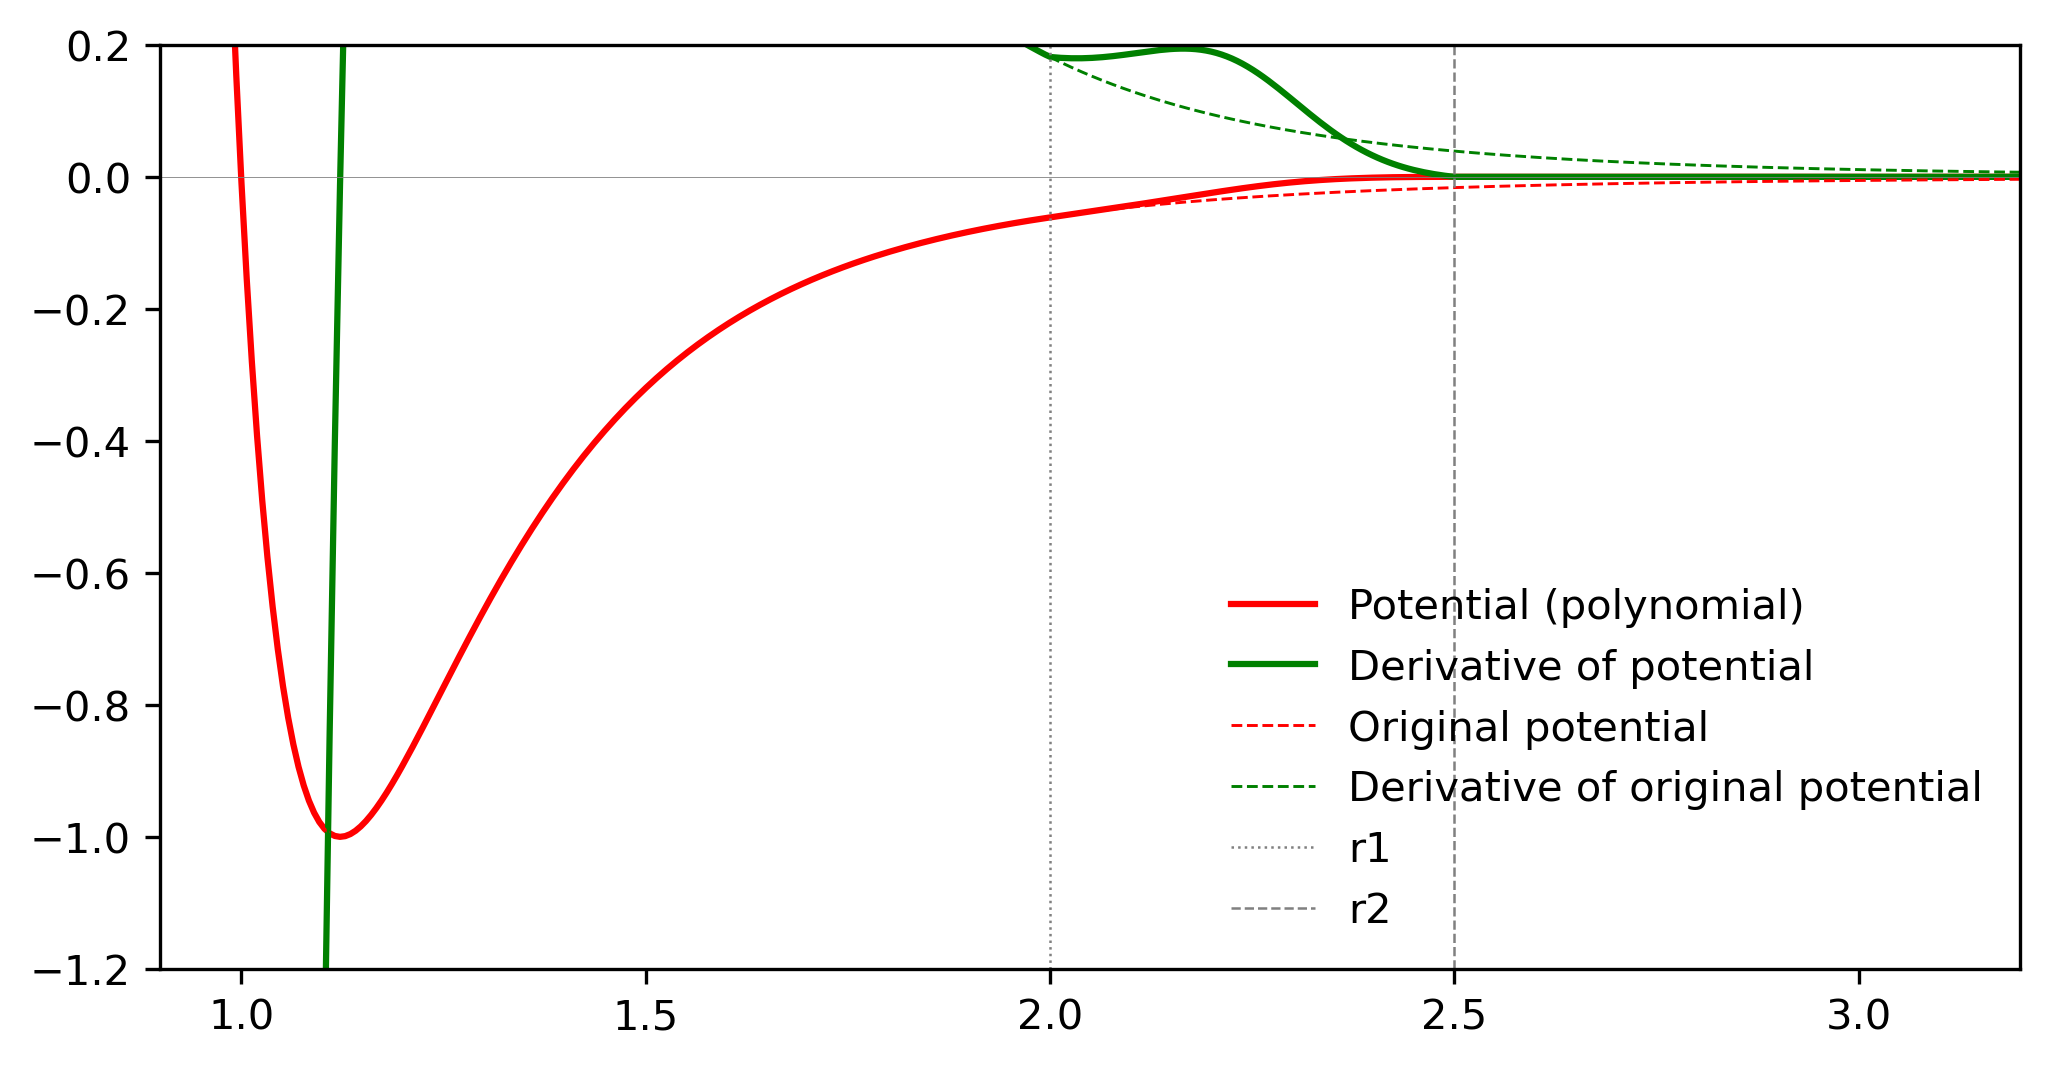

box:  [12.92660814 12.92660814 12.92660814]
Cutting distance:  2.5
Neighbourlist outer distance:  3.0
NB_dist:  3.0  BOX:  [12.92660814 12.92660814 12.92660814]
L = 12.927

step   1000 | 100.0 % | 13.12 ms/step

SimpleMD finished.


In [12]:
simulate(settings)

In [11]:
potential = smd.Potential("Lennard_Jones")
cutoff = smd.Cutoff(2.5, 0.8, "polynomial")
inter = smd.Interactions(potential, cutoff)

In [12]:
L = 12.0
N = 150
rng = np.random.default_rng()
xx = rng.random((N,3))*L
box = np.array((L,L,L))

# Analyze single simulation

## Energy plot

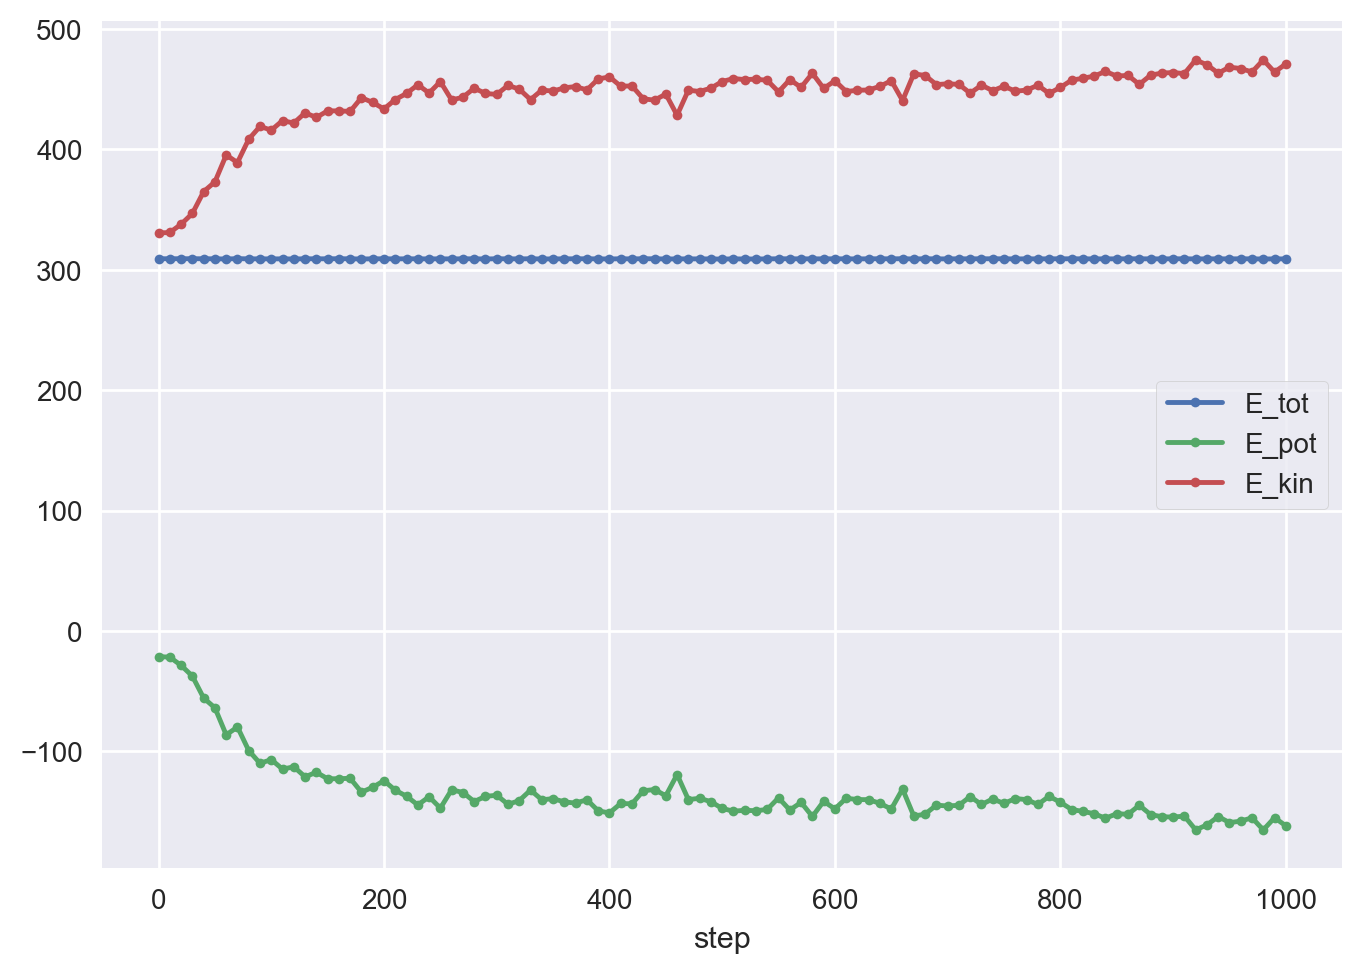

In [13]:
smd.plot_energy('energy.txt', 'step', 'E_tot', 'E_pot', 'E_kin')

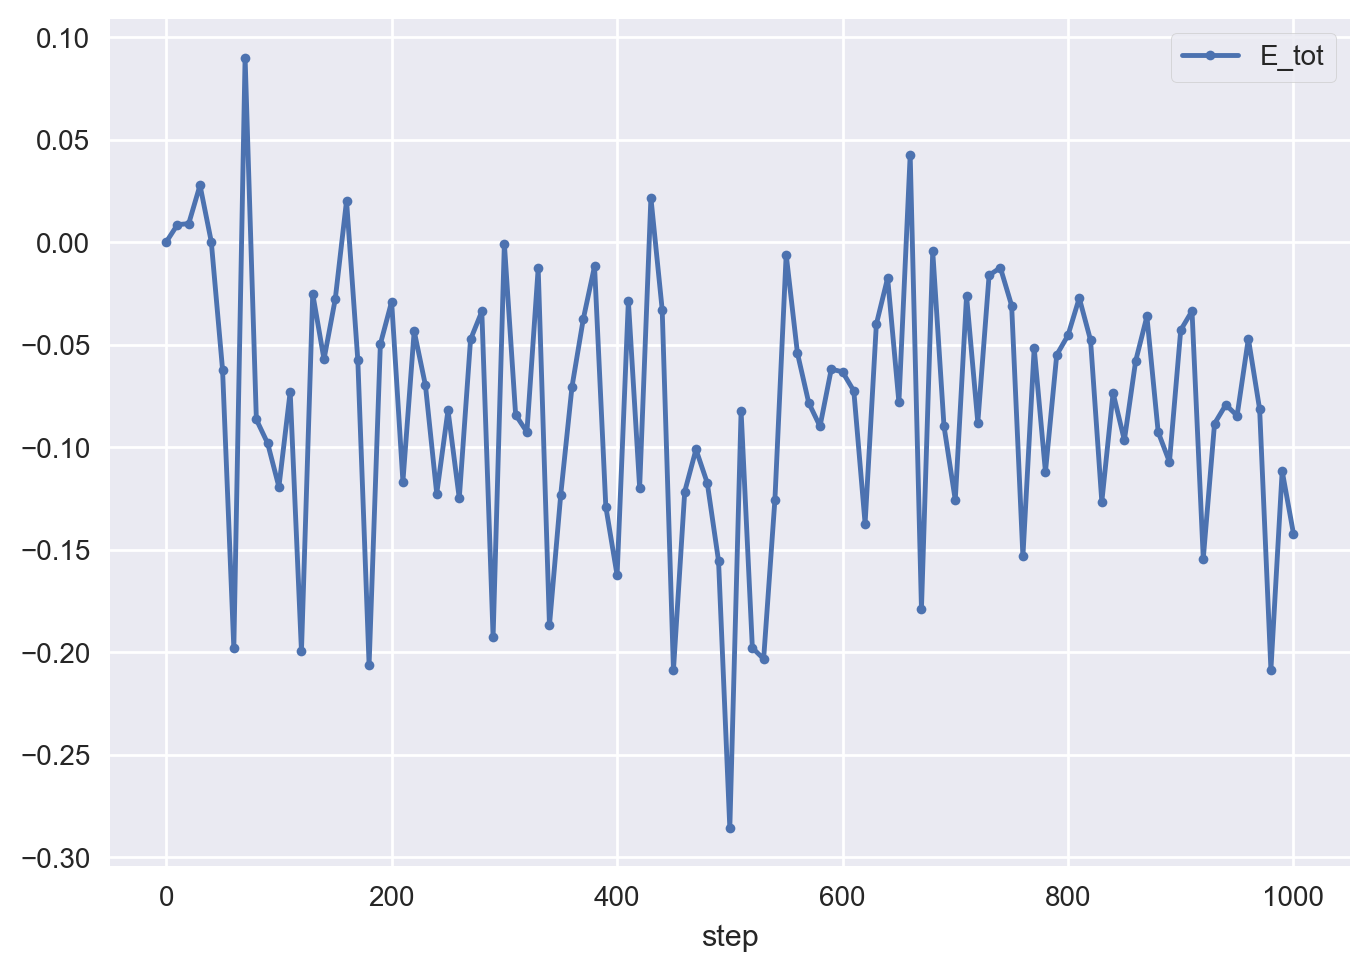

In [14]:
smd.plot_energy('energy.txt', 'step', 'E_tot', evolution=True)

## Radial distribution function

Box set up from rho: [12.926608140191302, 12.926608140191302, 12.926608140191302]


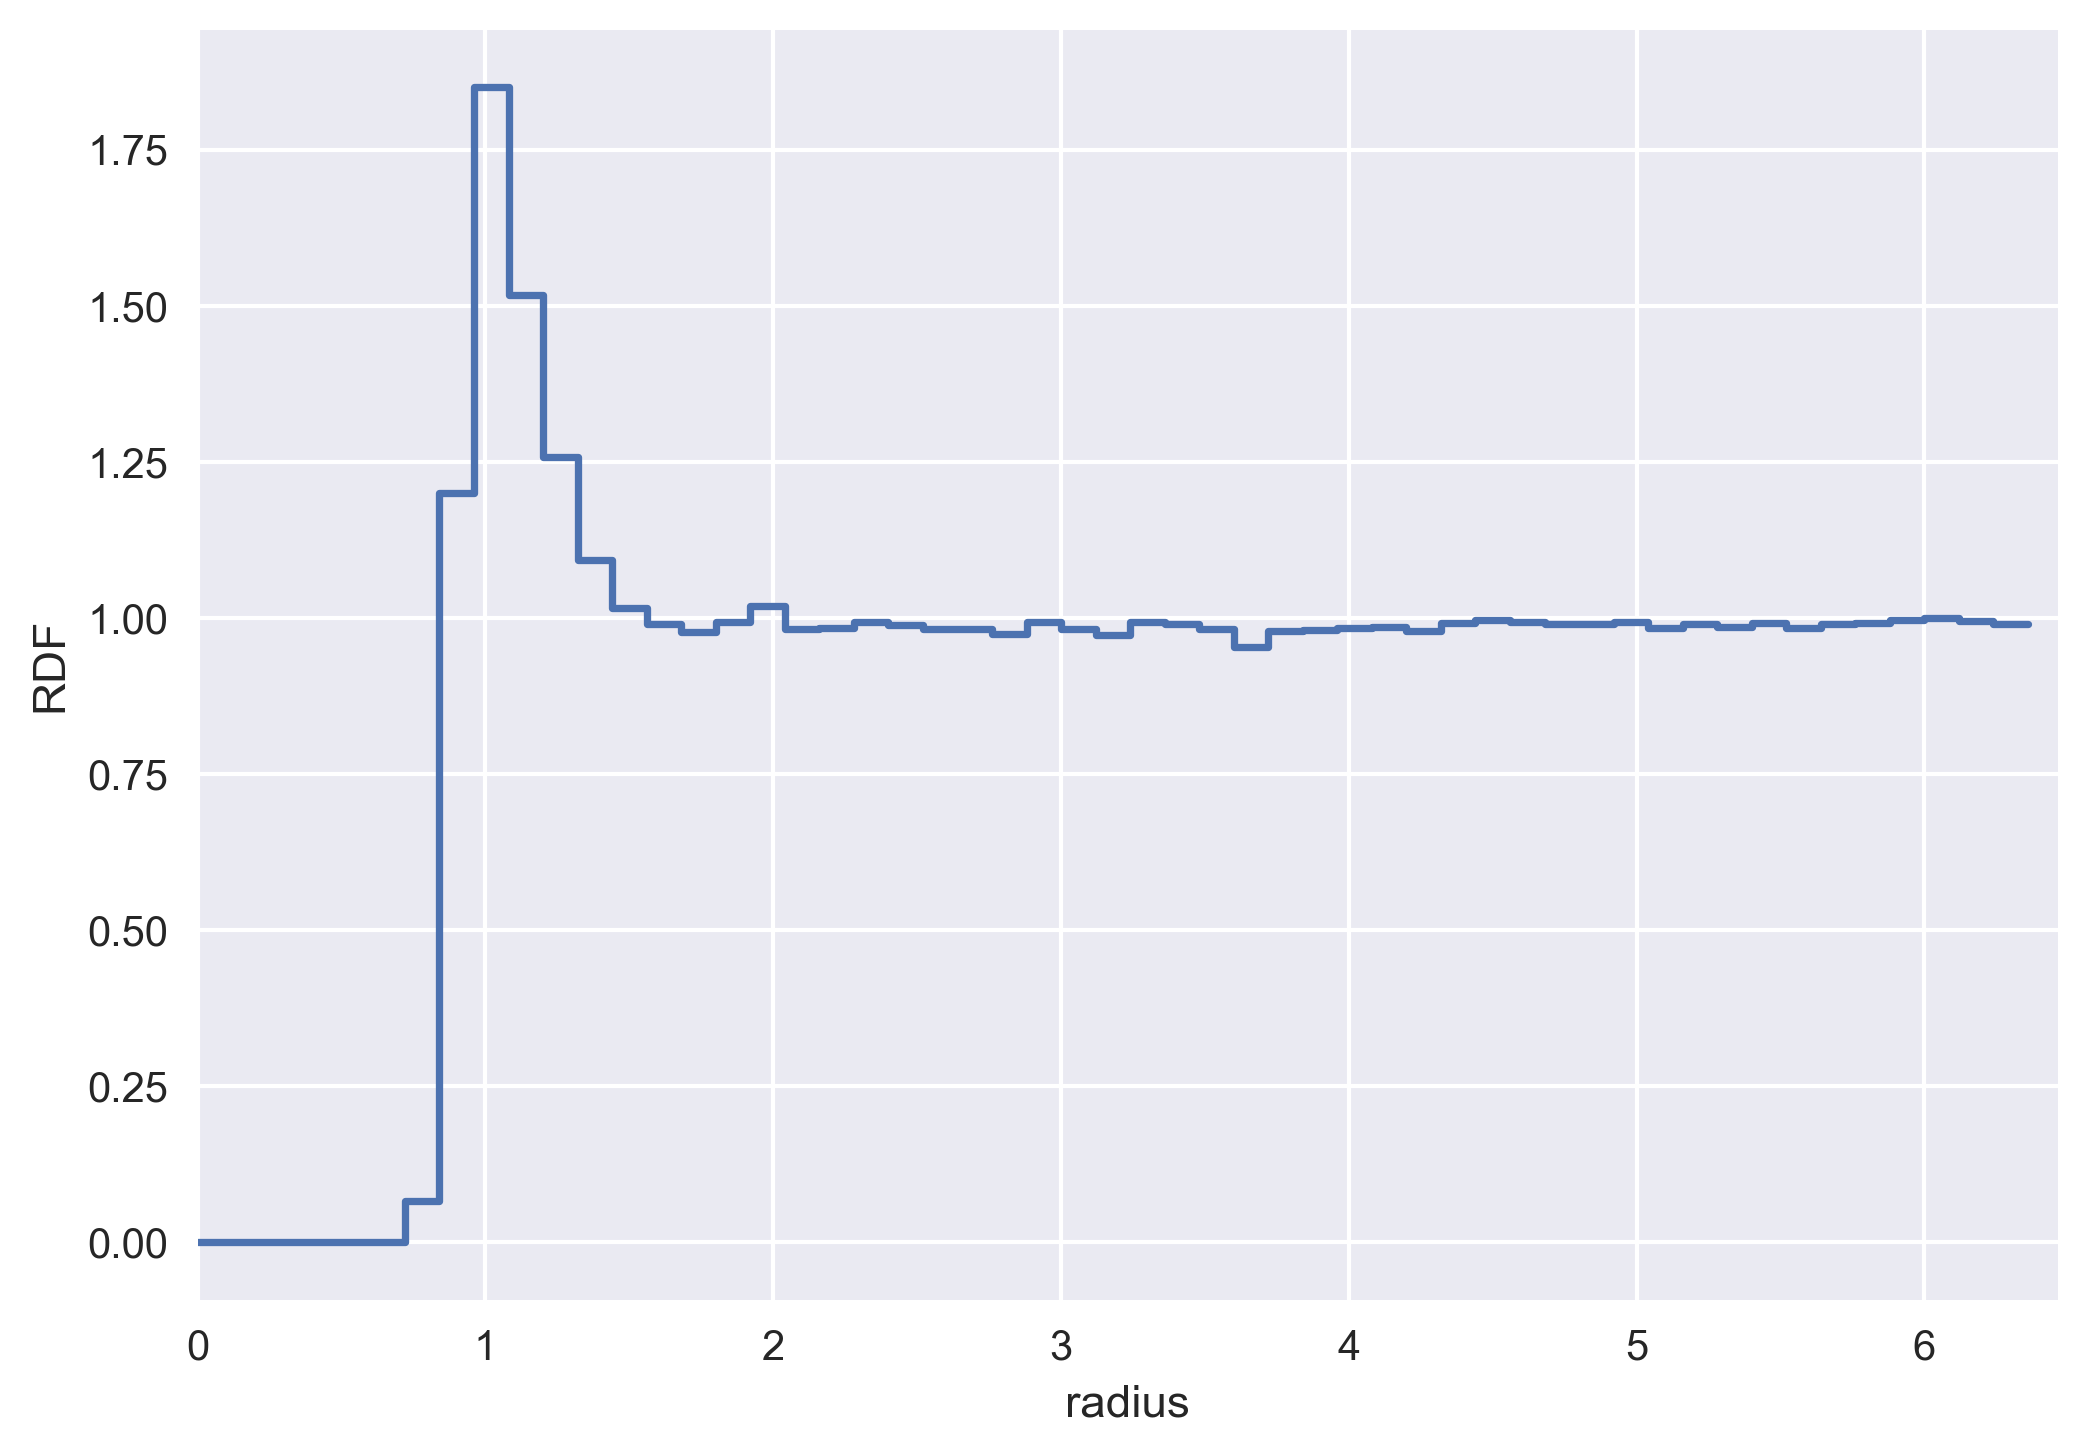

In [15]:
smd.get_rdf("positions.xyz", dr=0.12, skip_frames=4, rho=0.1, 
            plot=True, step_function=True)

# Simulation in batch - scanning variables

### Setup - dictionary of variable parameters and their values:

In [9]:
variable = dict(#cutoff = [{"cutoff_smoothing" : j} for j in ["linear", "shifted", "polynomial"]],
                #cutoff_ = [{"smoothing_length" : j} for j in [0.5, 0.9]],
                #cutoff__ = [{"cutoff_distance" : j} for j in [1.5, 2.0, 2.5]],
                #n_steps = [500, 1000, 2000],
                #sim_time = [20,],
                N_particles = [8, 27, 64, 125, 216],
                dt = [0.01,],
               )

### Run batch simulation:

Running configuration  1 / 5  ...   8  ;  0.01
    ... run  1 / 3  done
    ... run  2 / 3  done
    ... run  3 / 3  done
Running configuration  2 / 5  ...   27  ;  0.01
    ... run  1 / 3  done
    ... run  2 / 3  done
    ... run  3 / 3  done
Running configuration  3 / 5  ...   64  ;  0.01
    ... run  1 / 3  done
    ... run  2 / 3  done
    ... run  3 / 3  done
Running configuration  4 / 5  ...   125  ;  0.01
    ... run  1 / 3  done
    ... run  2 / 3  done
    ... run  3 / 3  done
Running configuration  5 / 5  ...   216  ;  0.01
    ... run  1 / 3  done
    ... run  2 / 3  done
    ... run  3 / 3  done
Everything has finished successfully!


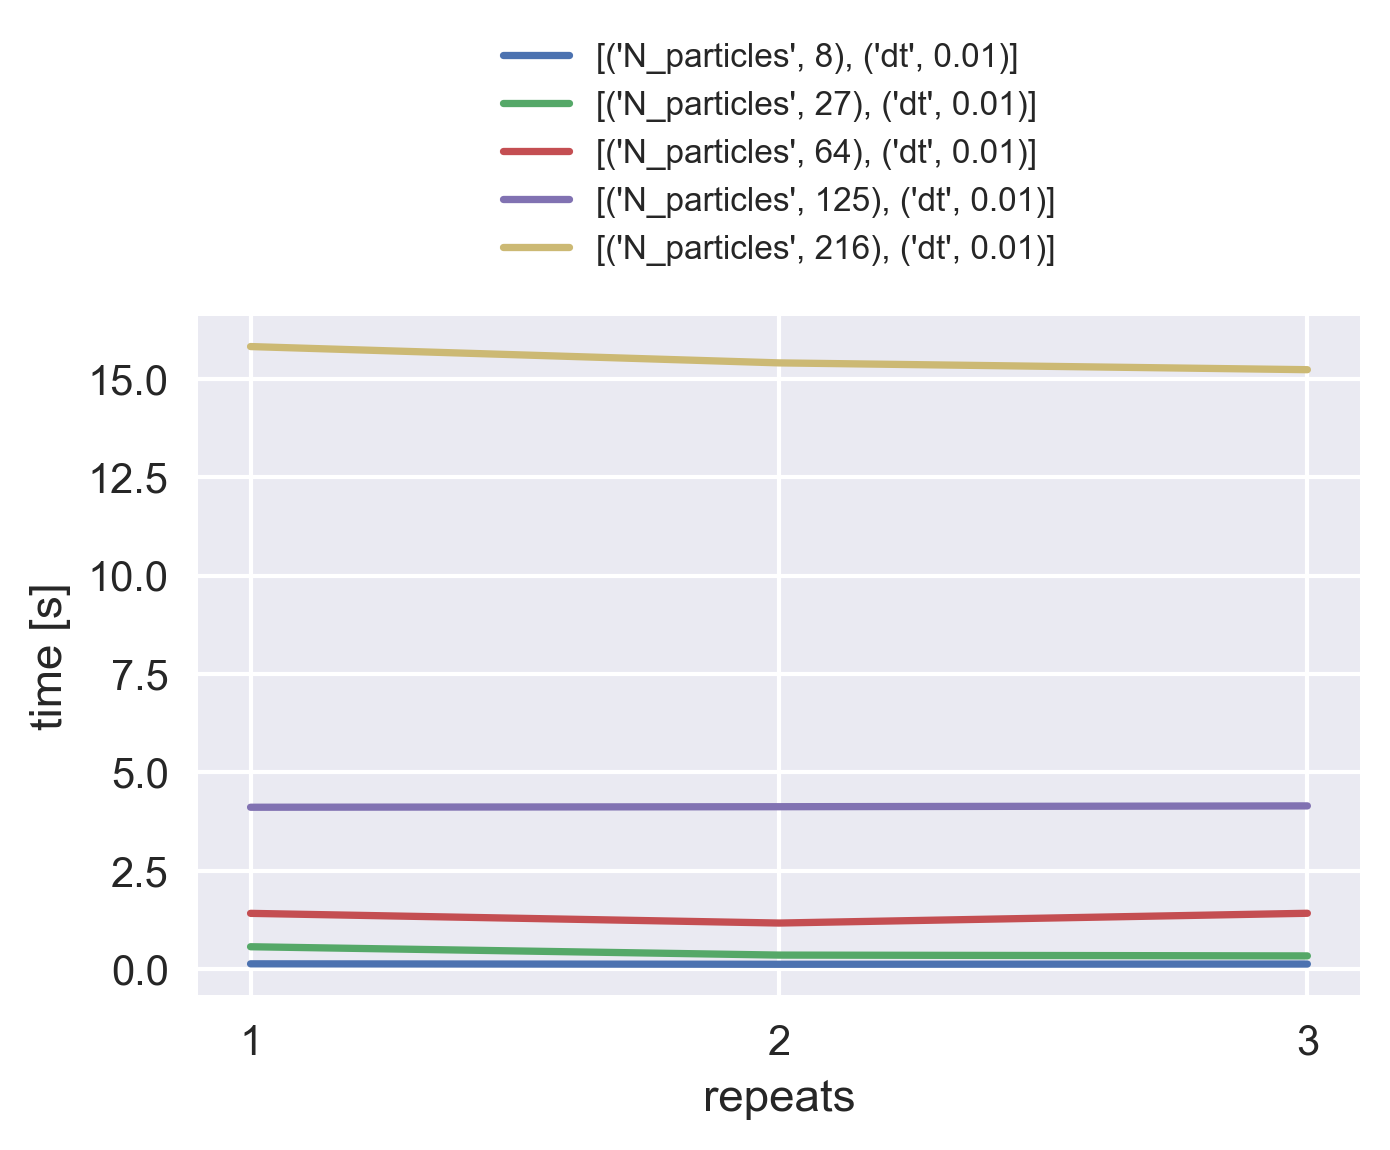

In [10]:
from simplemd_2 import batch_analysis as ba

time_data, folder = ba.measure_times(settings, variable, simulate, silent_mode=True, repeats=3, 
                             save_potentials=False, save_md_data=True, save_time_data=True)

# Batch run analysis (experimental) - dash + plotly

In [11]:
from simplemd_2 import plot_with_plotly as pwp

#pwp.plot_with_plotly(time_data)
pwp.plot_with_plotly("runtime_data.csv")

## Multi energy

In [1]:
from simplemd_2.batch_analysis import format_energy_files_to_pandas as to_pd
from simplemd_2.batch_analysis import plot_energy_from_pandas as plot_pd

In [12]:
folder = "./"+folder

In [13]:
folder

'./batch_2021-08-19_18-18_mds'

In [5]:
folder = "C:/Users/Michal Ptáček/Desktop\images_md\TH_series\TH_series_files_batch"

In [6]:
data = to_pd(folder, "energy", 
             columns=['time', 'E_pot', 'E_tot', 'E_kin'], 
             mean=False)

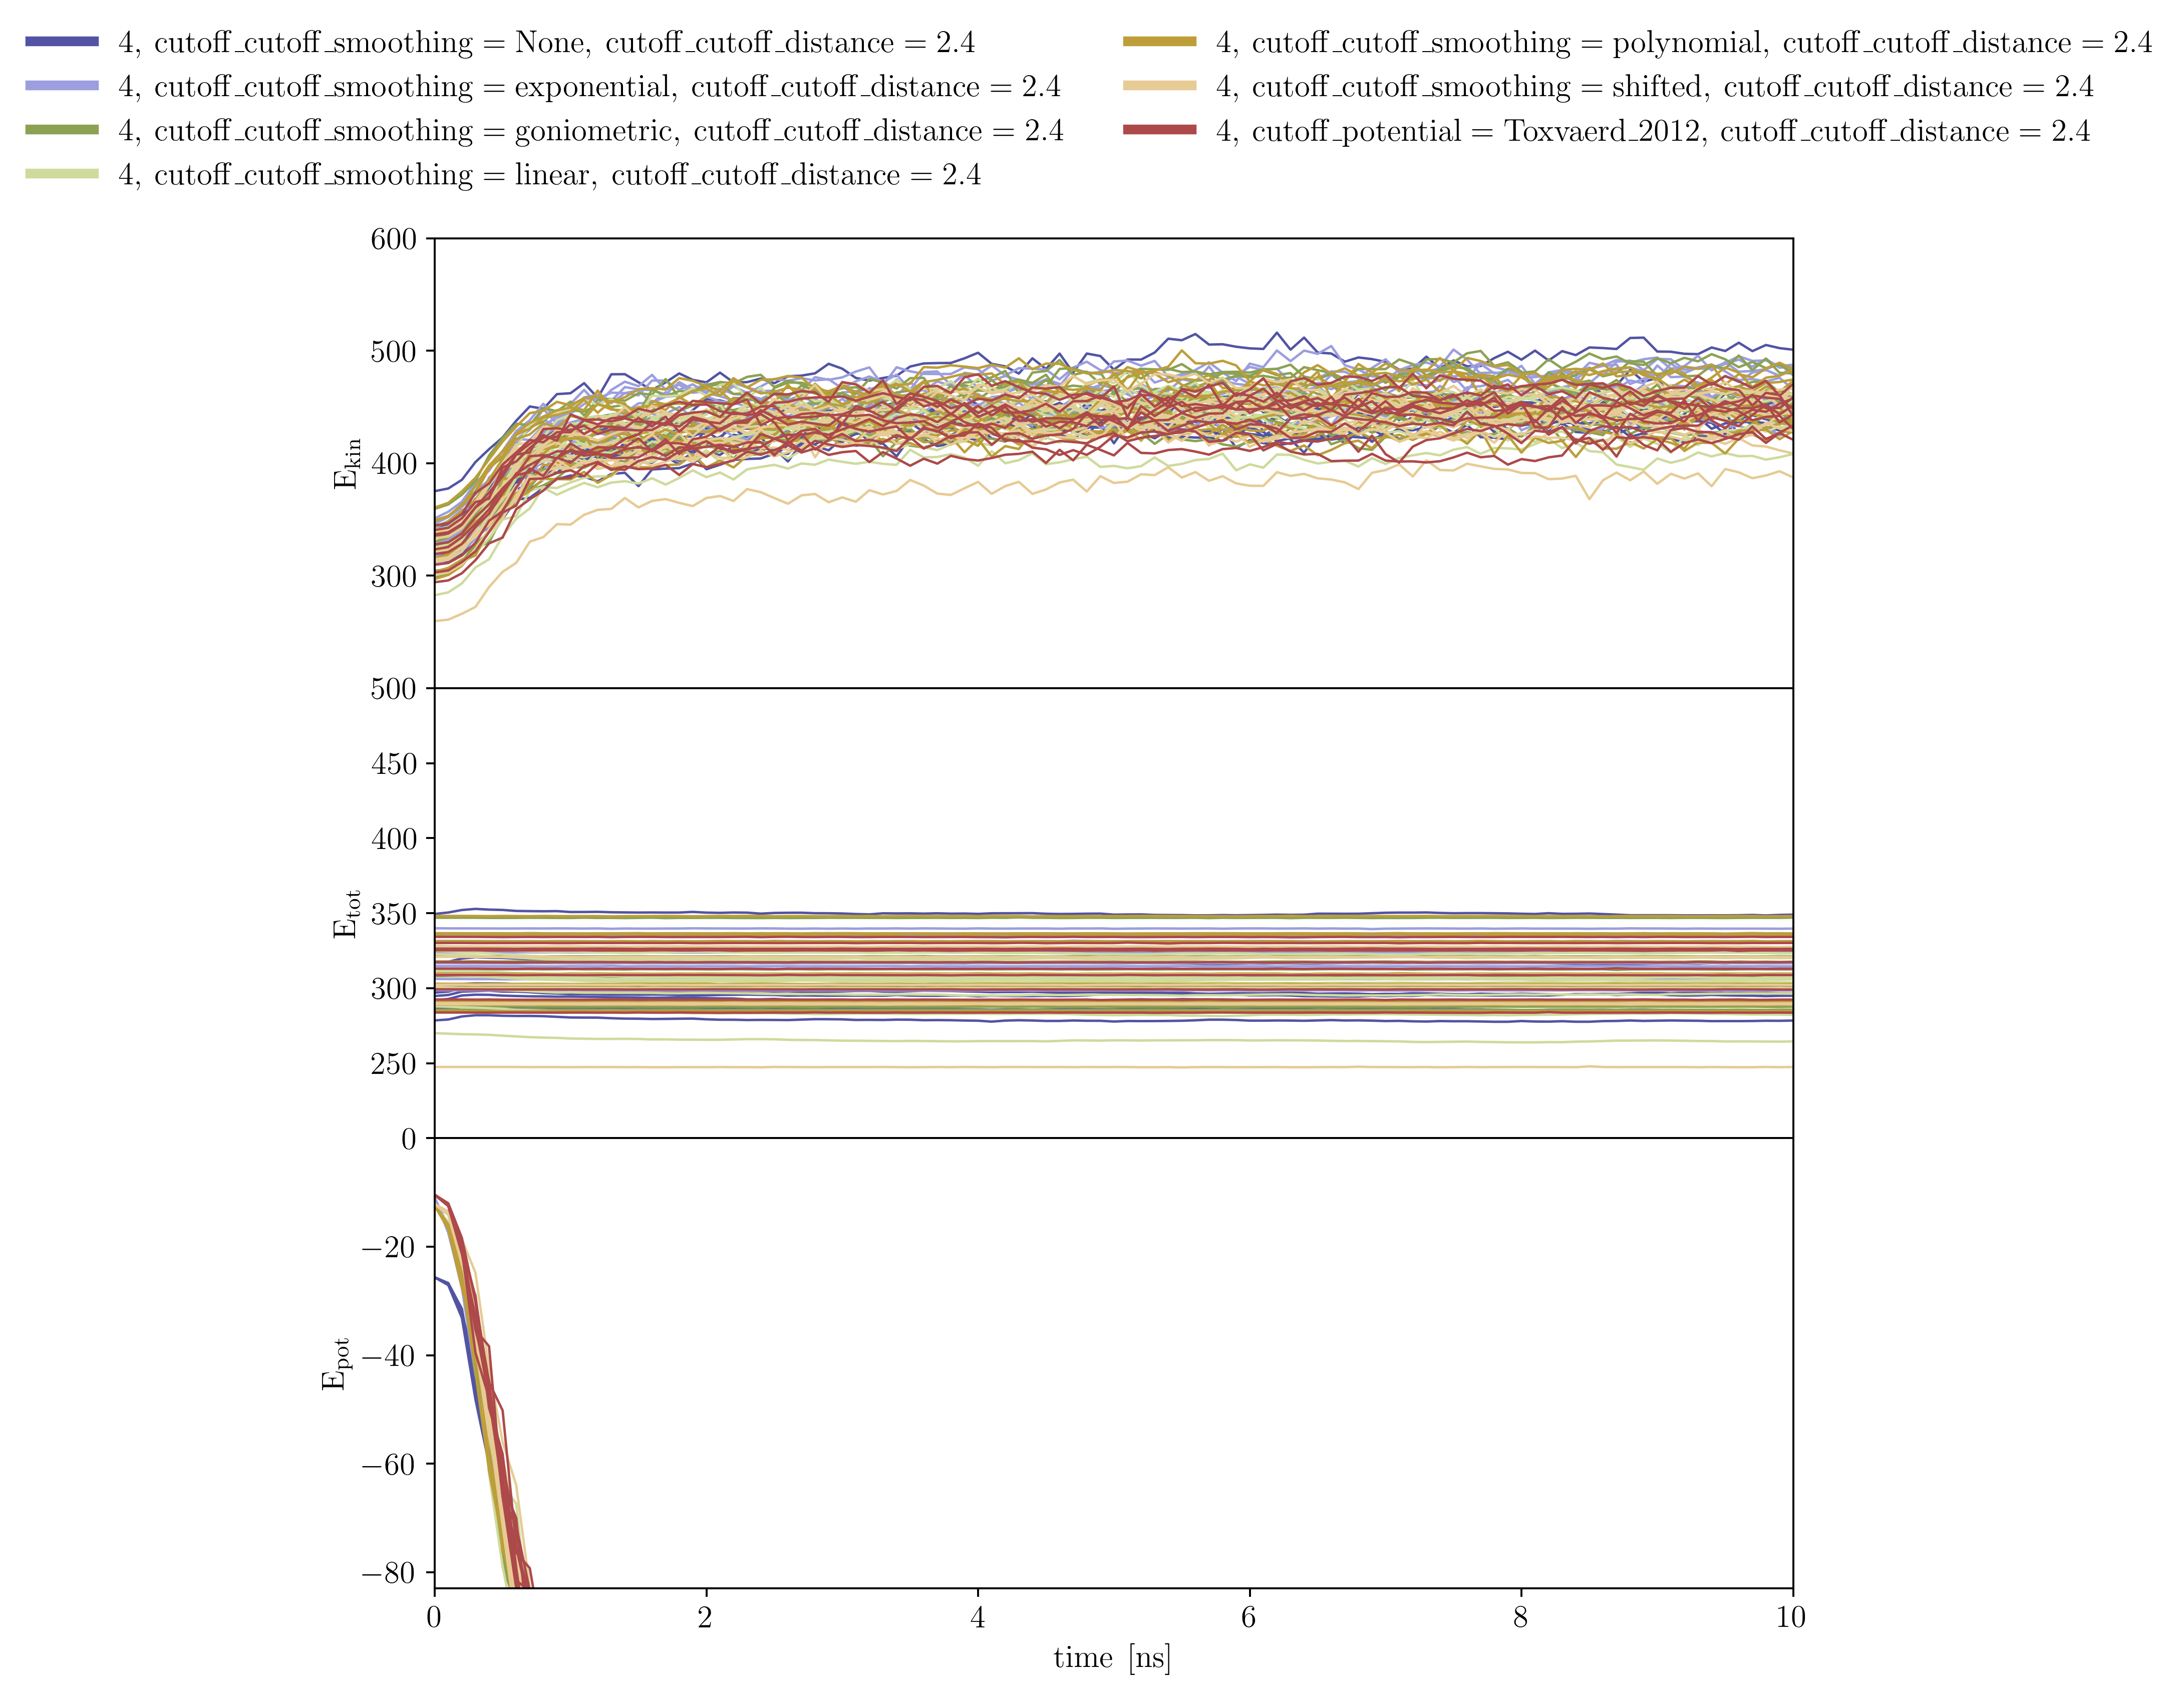

In [7]:
plot_pd(data, xlim_max=10, ylimits={'E_kin':(250,550), 'E_tot':(210,390), 'E_pot':(-160,10)}, 
        lvl0_order=(0,2,1), hide_bottom_label=False, legend_linewidth=4.0,
        savefig=folder+'/image.png',)

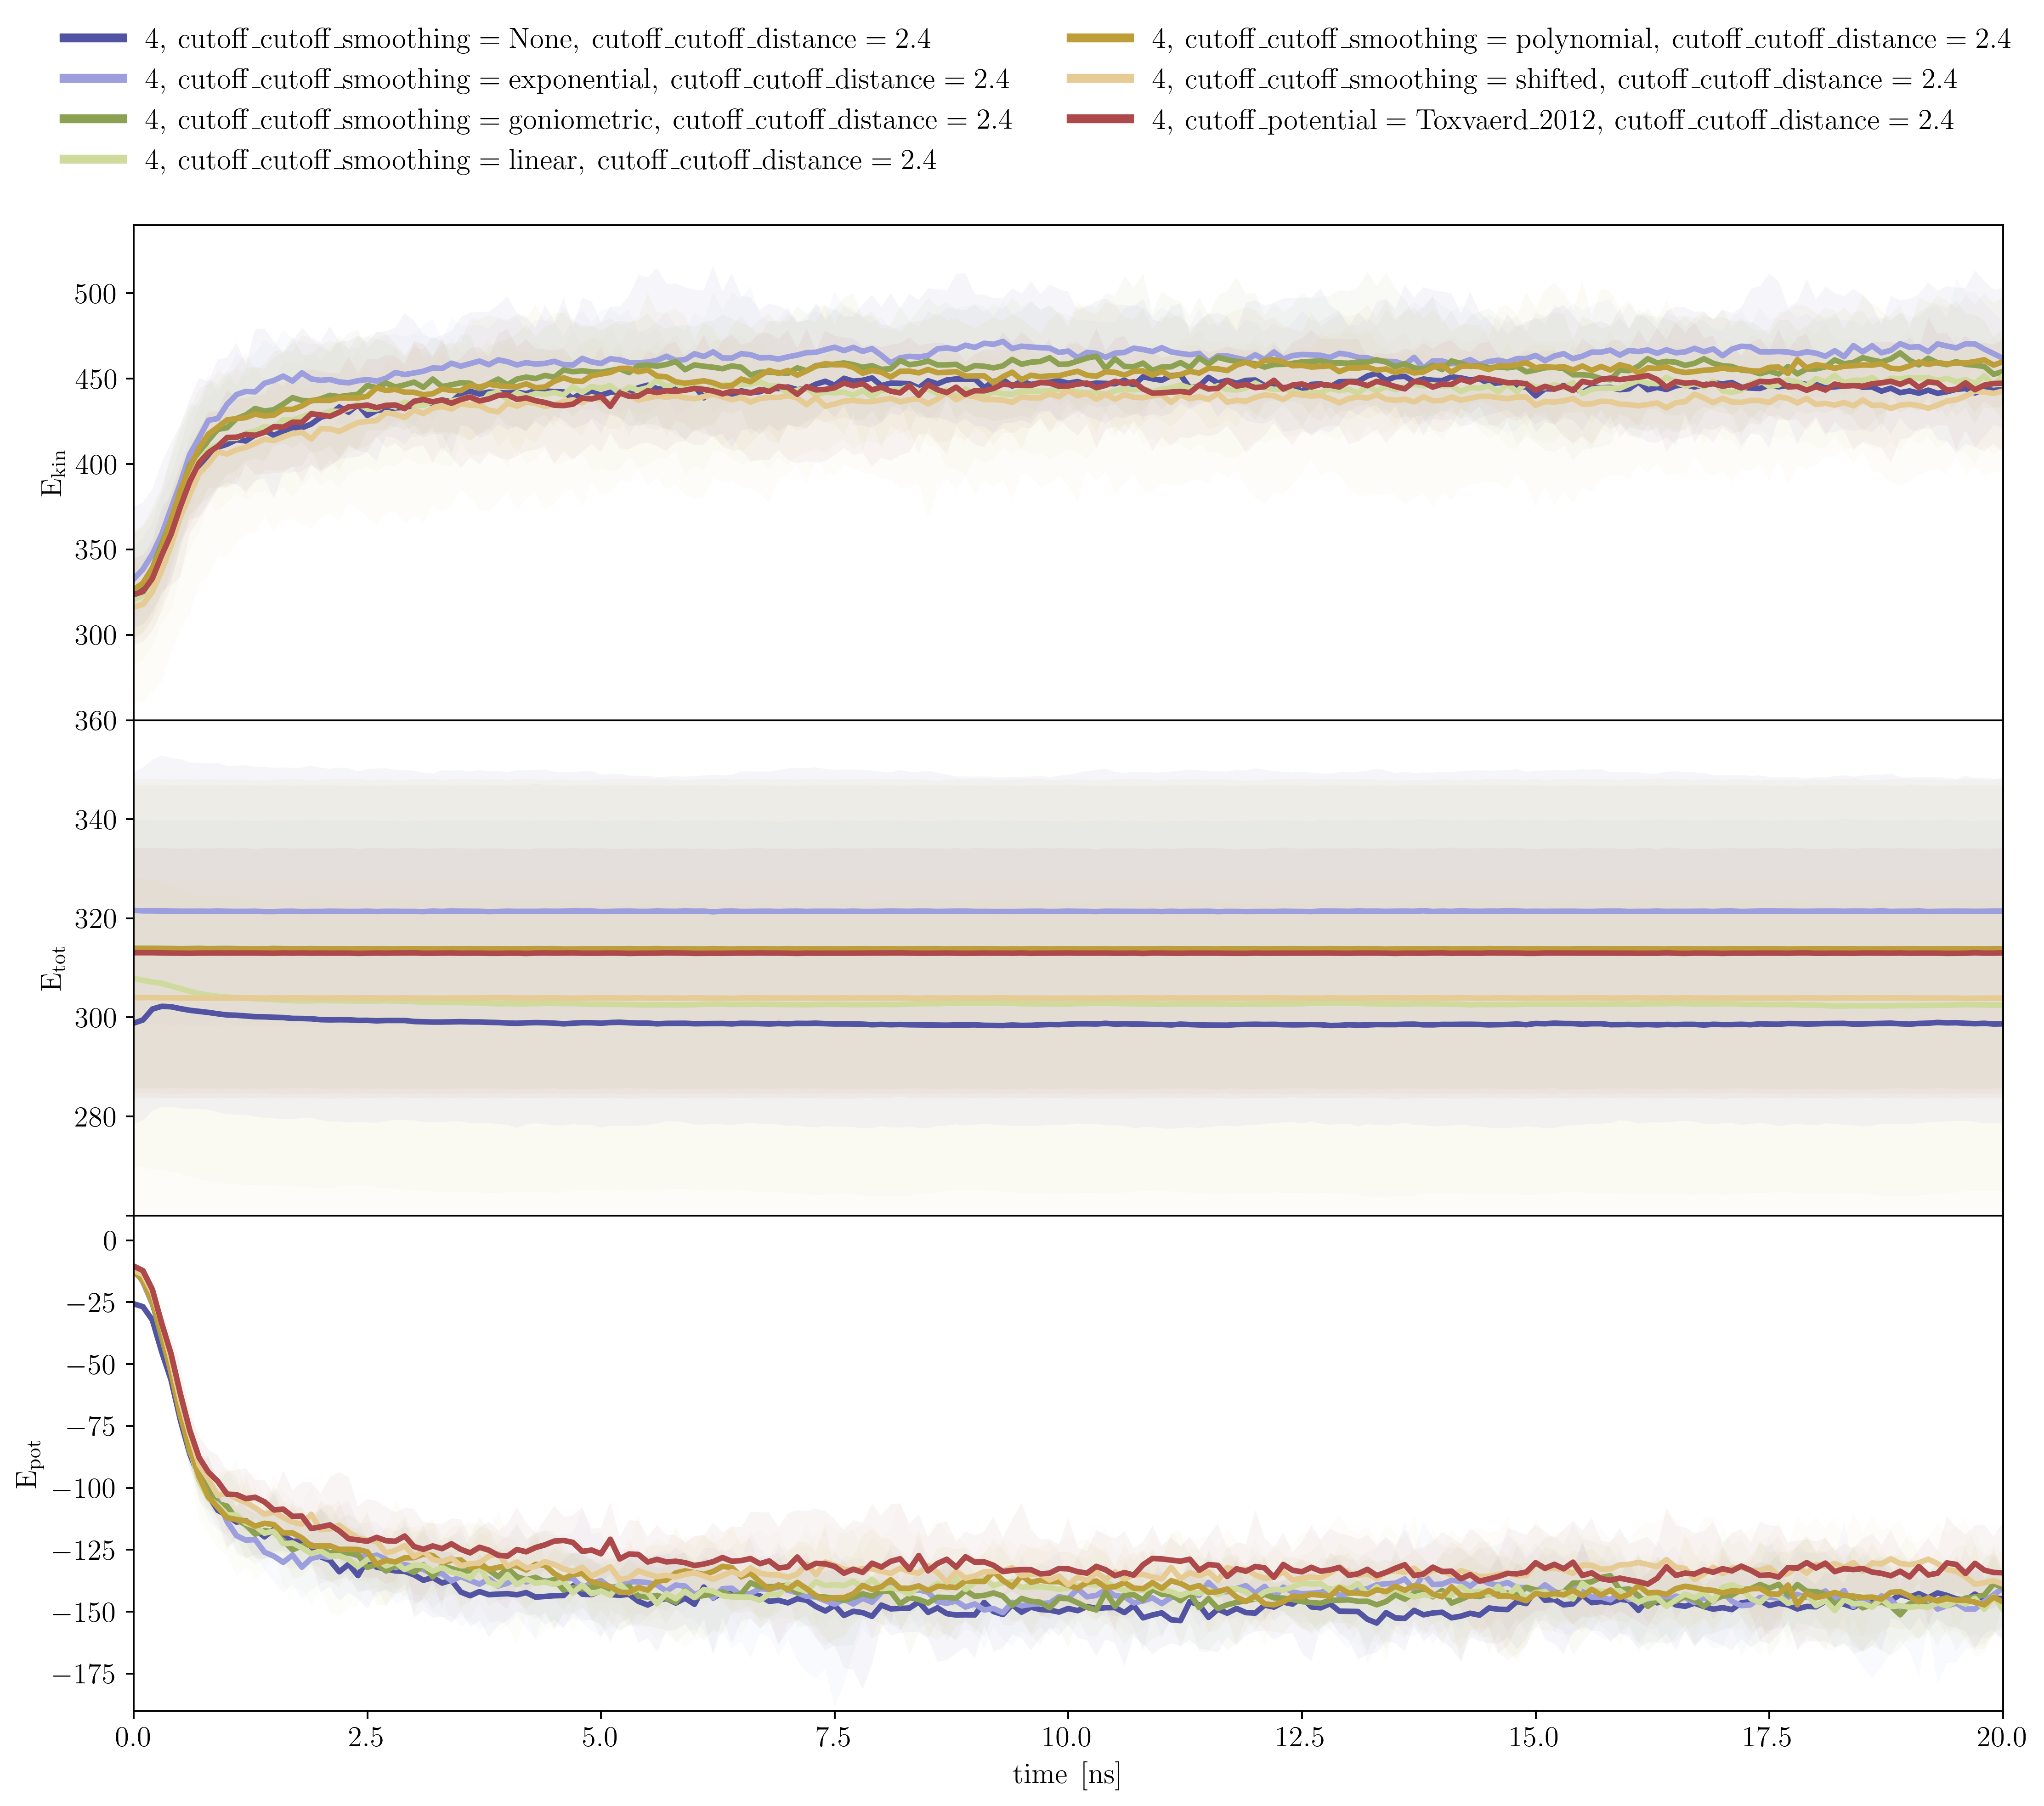

In [21]:
plot_pd(data, xlim_max=20, ylimits={'E_kin':(250,540), 'E_tot':(260,360), 'E_pot':(-190,10)}, linewidth=2.5,
        lvl0_order=(0,2,1), hide_bottom_label=True, legend_linewidth=4.0, display_means=True, area_alpha=0.05,
        savefig=folder+'/image.png', figsize=(15,12)
       )

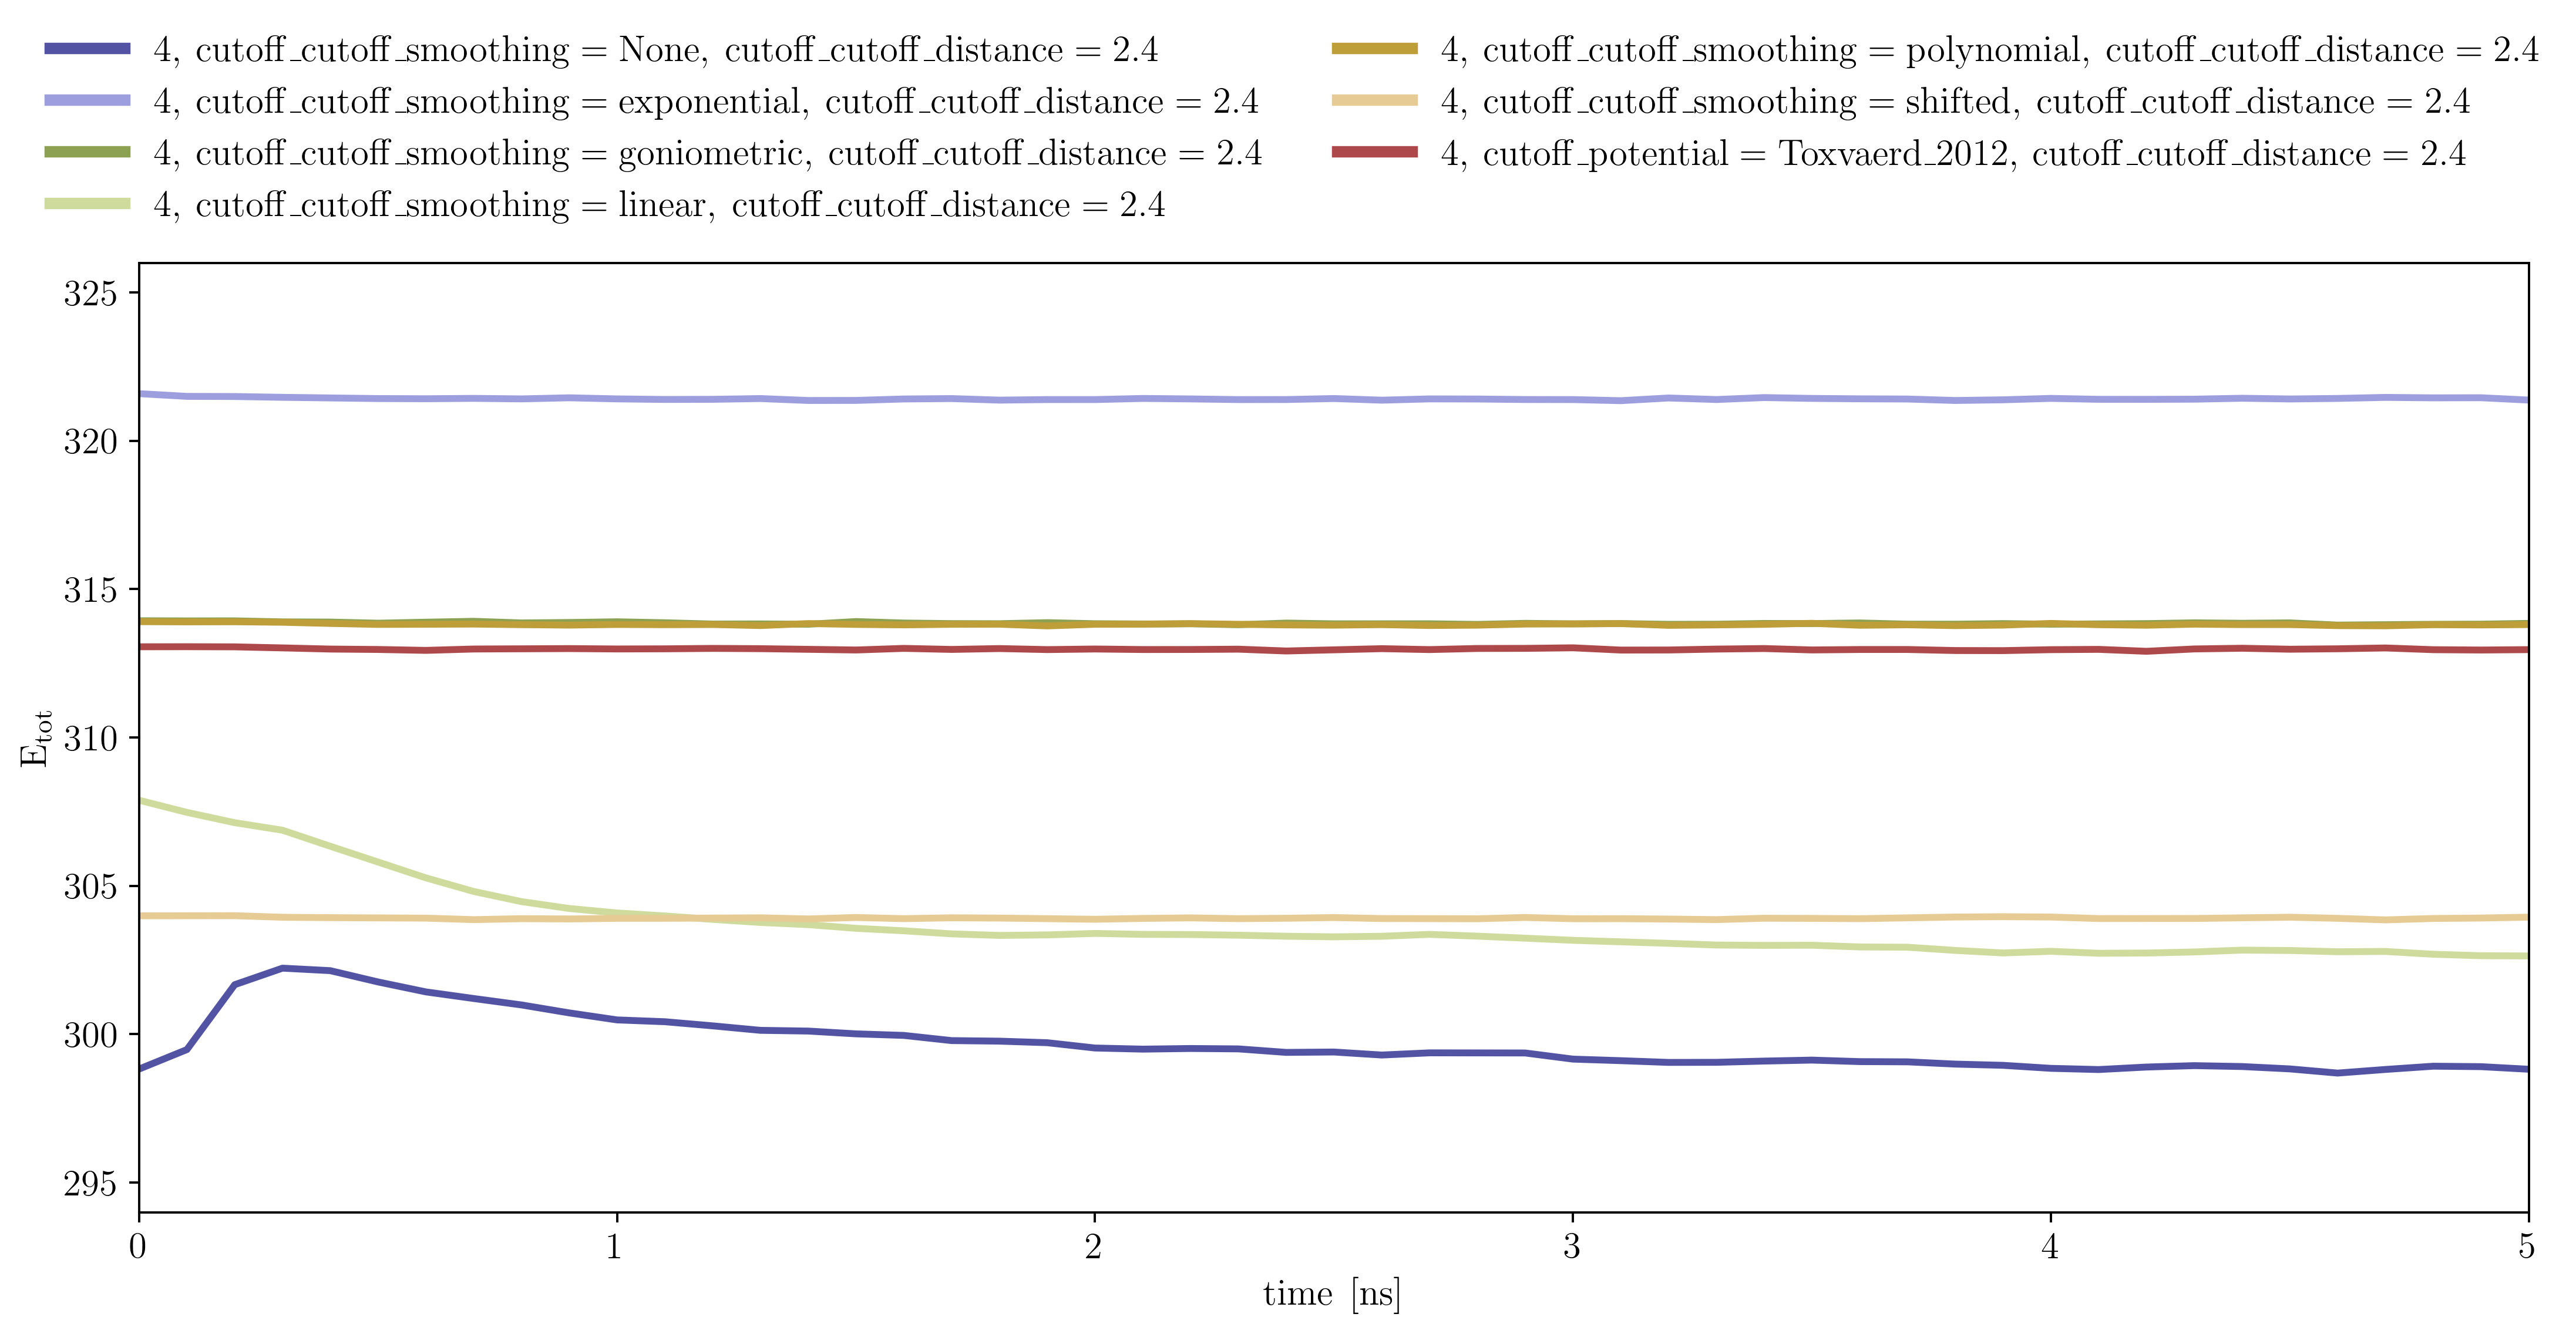

In [22]:
from simplemd_2.batch_analysis import plot_single_plot as psp

psp(data, 'E_tot', ylimits=(294,326), xlim_max=5, linewidth=2.4, figsize=(15,6), legend_linewidth=4.0,
   savefig=folder+"/single_plot.png")

In [5]:
from simplemd_2.batch_analysis import plot_runtimes
import os

In [6]:
path = 'C:/Users/Michal Ptáček/Desktop/images_md'
folder = 'NZ_series'

infolder = os.path.join(path,folder)

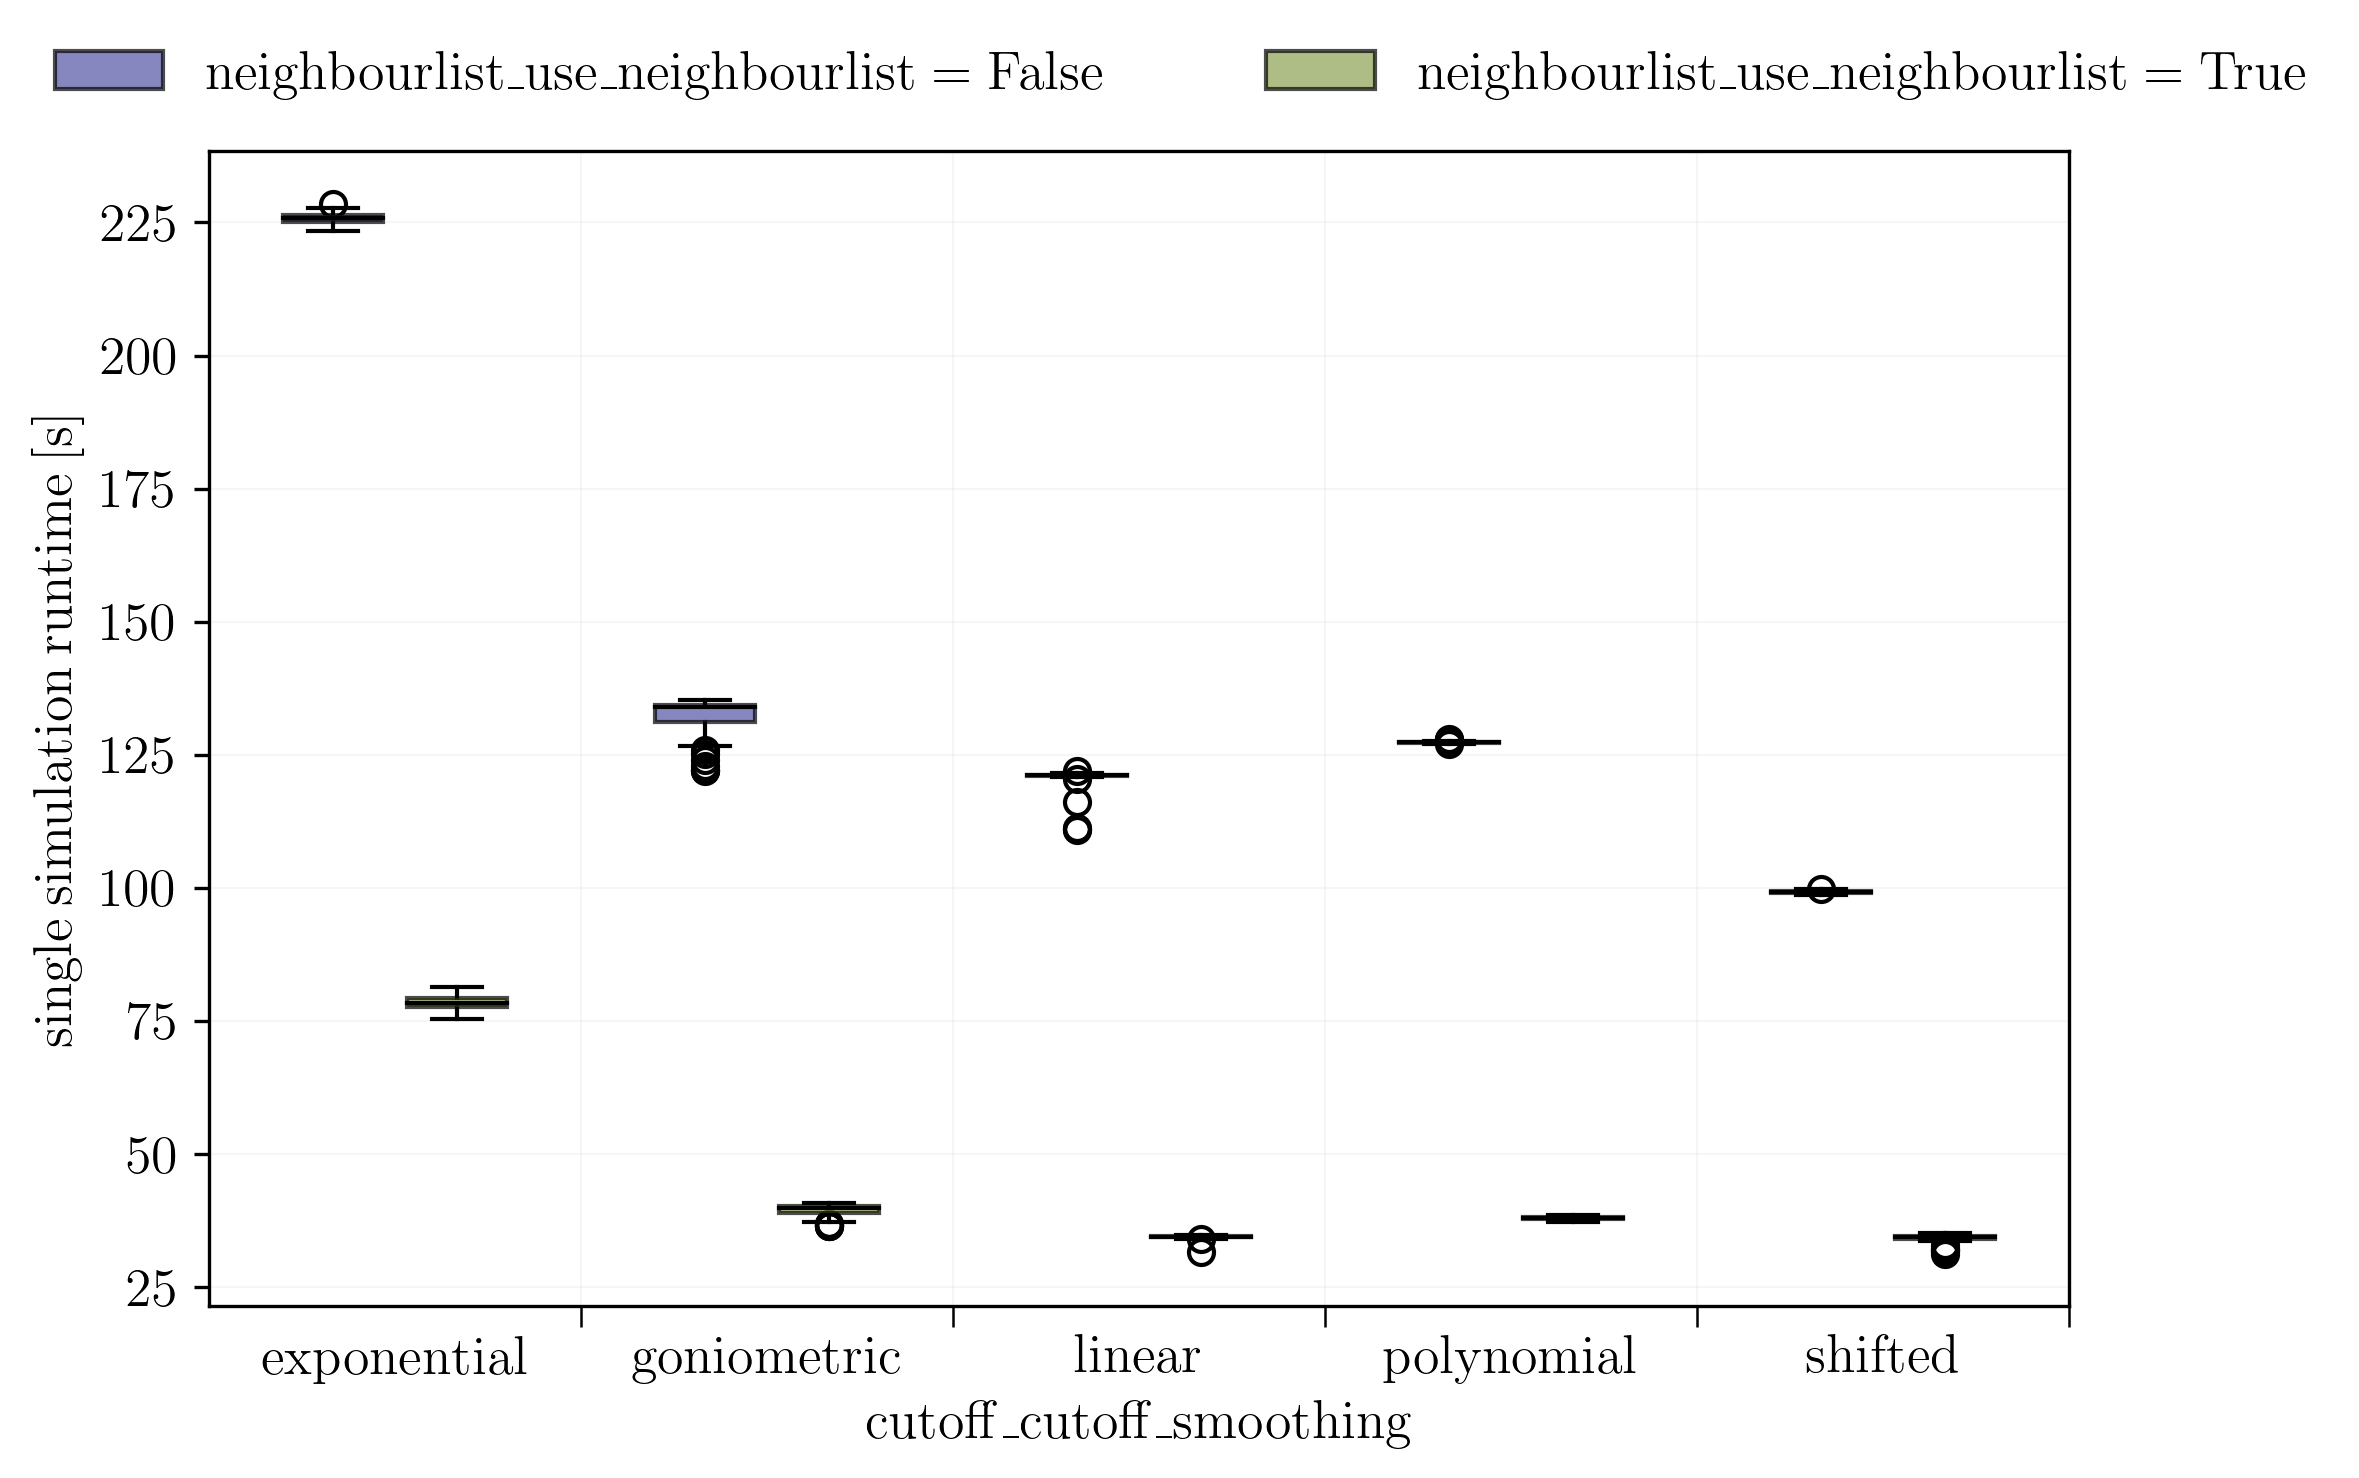

In [7]:
plot_runtimes(infolder, savefig=os.path.join(infolder, 'image_times.png'))

## Multi RDF

In [11]:
from simplemd_2 import batch_analysis as ba

In [9]:
# 
dtfrm, comments = ba.get_rdf_to_pandas(folder, "positions", rho=0.1, give_dataframe=True, save_to_csv=False)

This process is going to take some time ...
Evaluating files ...
 ... done in 3.91 s

Transposing and sorting data ...
 ... done in 0.07 s

Done in 3.98 s


In [10]:
xaxis, data, comments = ba.get_multi_rdf(folder, 
                                         dr=0.2, 
                                         rho=0.1, 
                                         frame_start=3,
                                        )

time: 5.0, 2__cutoff_smoothing_length--0.9__dt--0.01 
Done in 1.48 s


In [3]:
# load from last call
xaxis, data, comments = ba.load_multi_rdf(folder)

Initializing ...
Loading from lastcall file done ...
{'box': [12.926608140191302, 12.926608140191302, 12.926608140191302], 'repeats': 20, 'N': 216, 'shape': [1180, 464400], 'rho': 0.1, 'folder': './batch_2021-08-13_22-28_mds'}


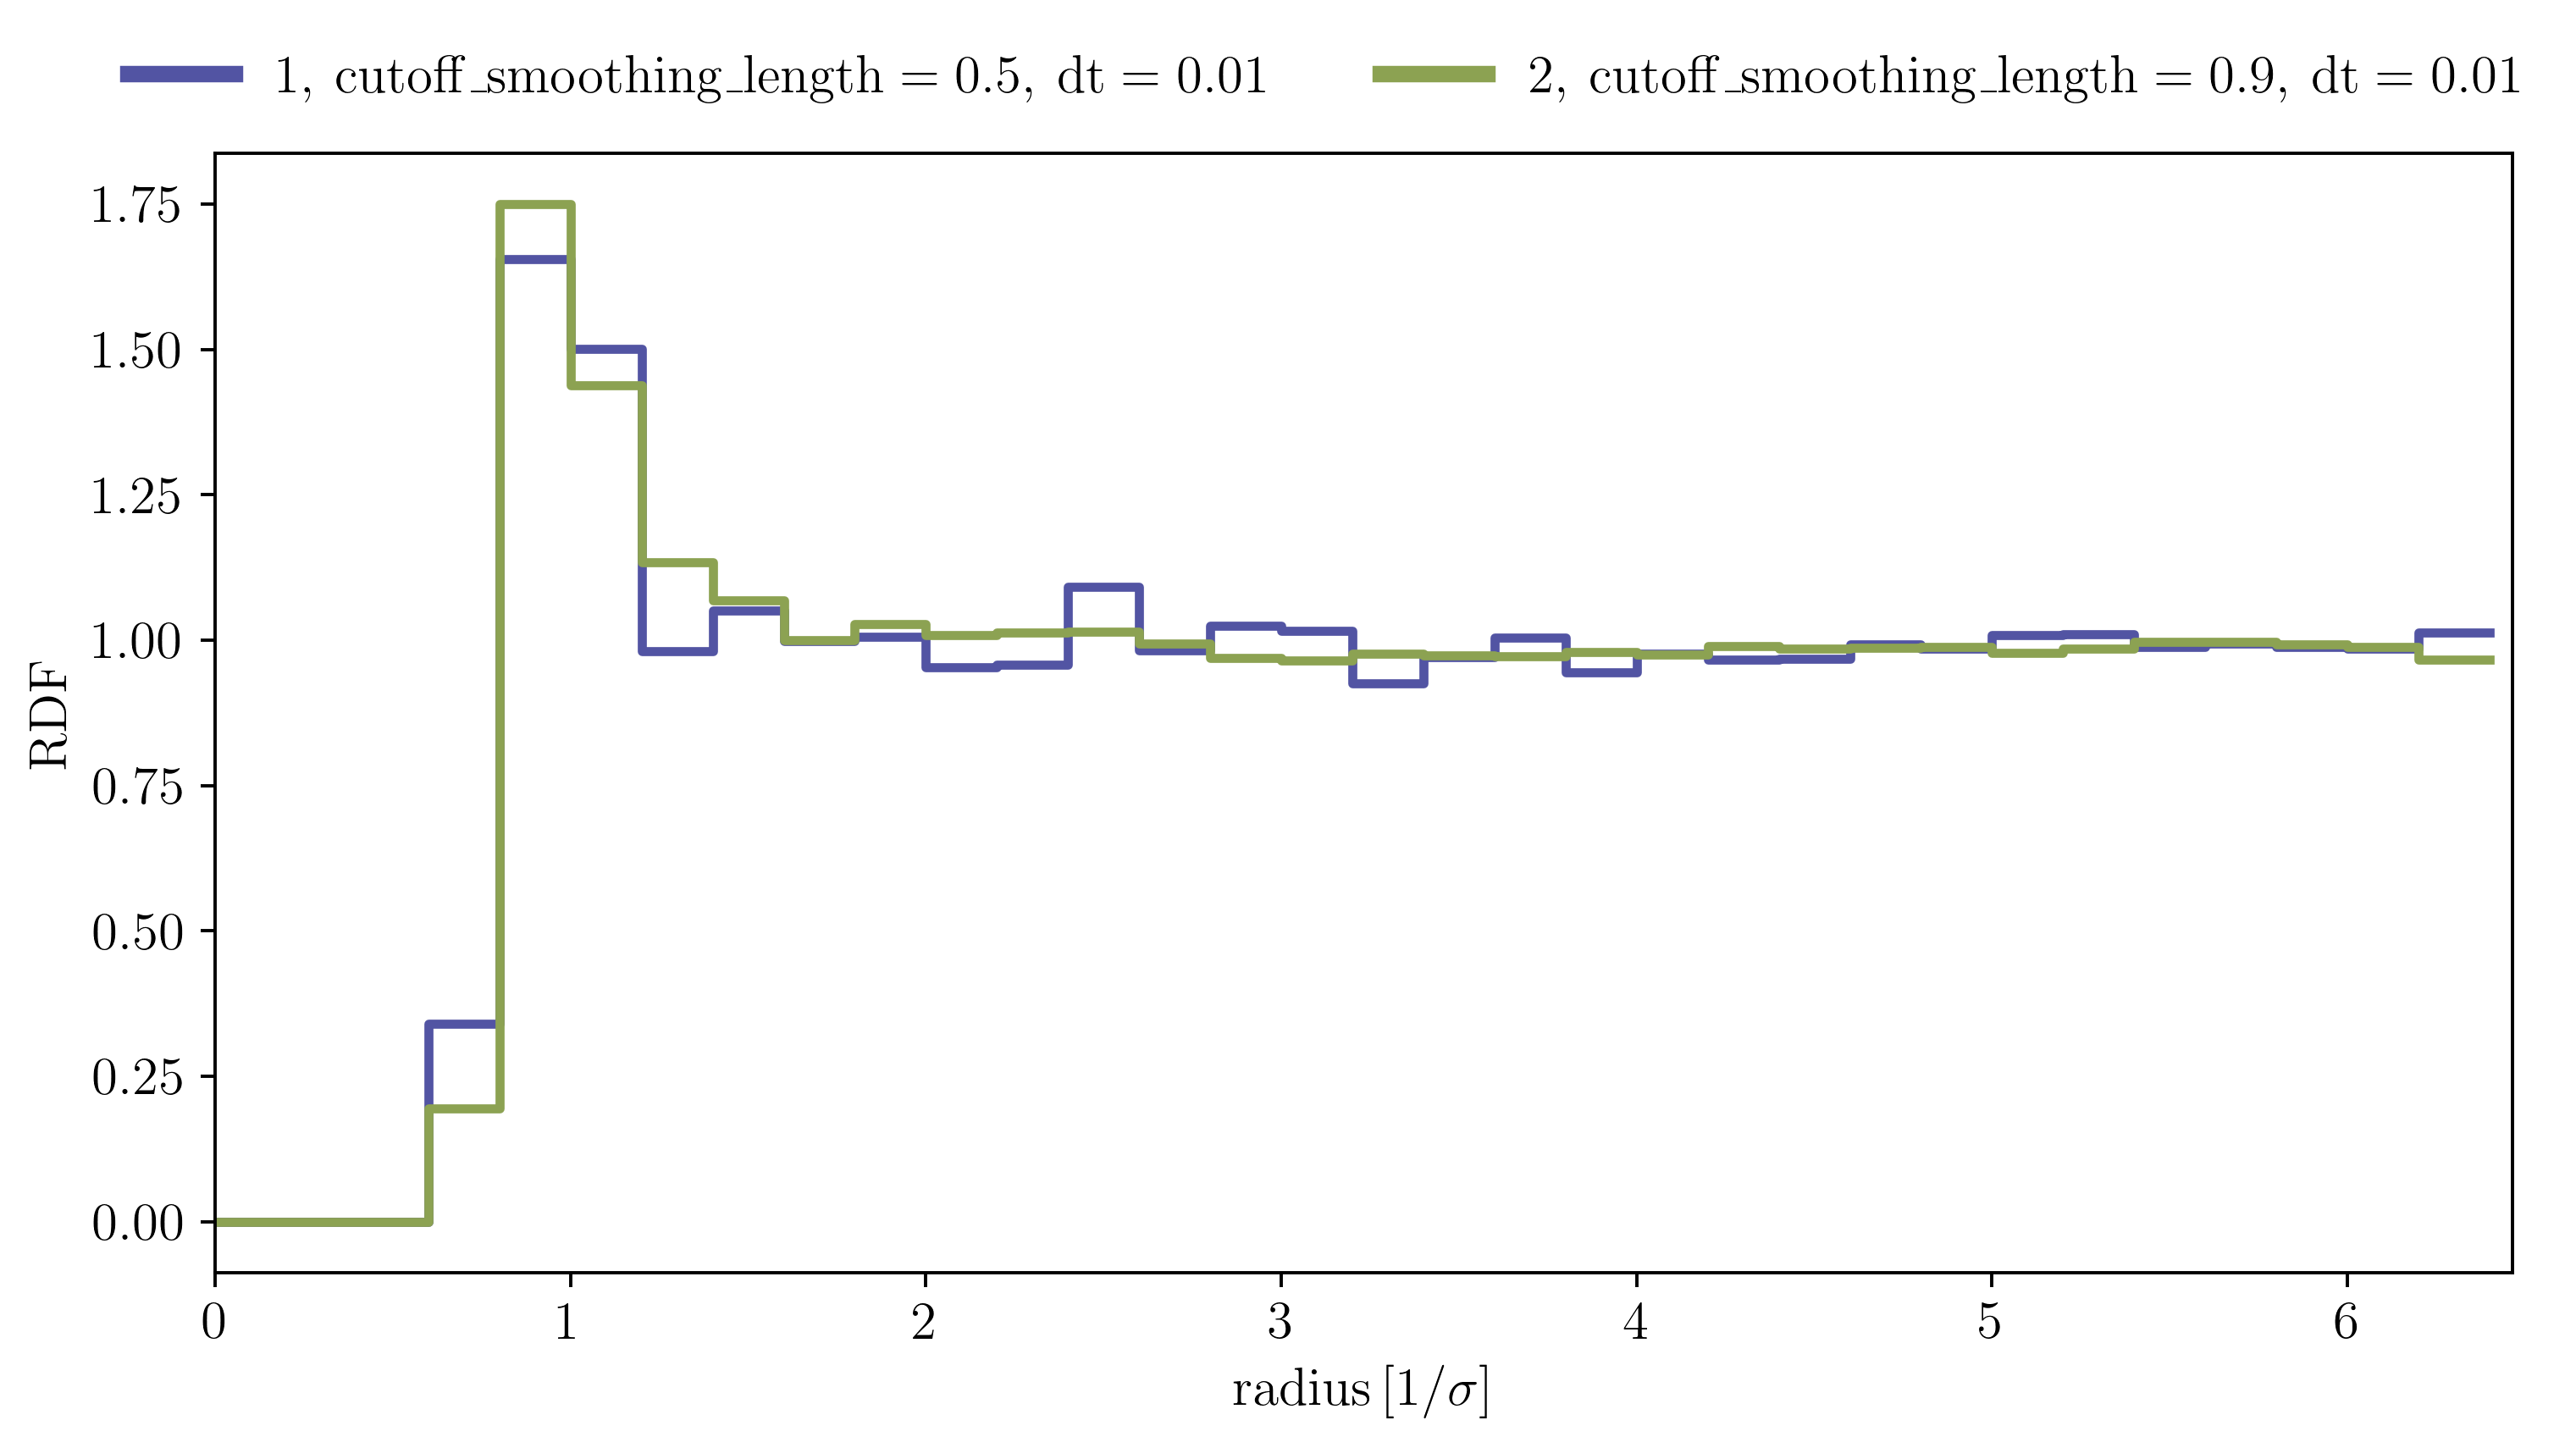

In [11]:
ba.plot_multi_rdf(xaxis, data, comments['box'], 
                  step_function=True, 
                  legend_linewidth=4.0, linewidth=2.2,
                  savefig=folder+'/image_rdf.png',
                 )